In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from netCDF4 import Dataset
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
dst_crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
from pyresample.geometry import AreaDefinition

%matplotlib inline

In [2]:
idir = '/Data/sat/downloads/CS2/SIR_GDR/2021/01'

ifiles = sorted(glob.glob(f'{idir}/CS_OFFL_SIR_GDR_2__2021010[1-5]*nc'))
print(len(ifiles))



70


In [3]:
#!ncdump -h /Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T011921_20210101T025835_D001.nc

In [19]:
rho_water = 1026
rho_snow = 400
rho_ice = 917

orbits = []
min_lat = 70
min_sic = 0
for ifile in ifiles:
    print(ifile)
    ds = Dataset(ifile)
    freeboard_20_ku = ds['freeboard_20_ku'][:]
    lat_poca_20_ku = ds['lat_poca_20_ku'][:]
    lon_poca_20_ku = ds['lon_poca_20_ku'][:]

    time_20_ku = ds['time_20_ku'][:]
    time_cor_01 = ds['time_cor_01'][:]

    snow_depth_01 = ds['snow_depth_01'][:]    
    f = interp1d(time_cor_01.filled(np.nan), snow_depth_01.filled(np.nan), bounds_error=False)
    snow_depth_01 = f(time_20_ku.filled(np.nan))

    sea_ice_concentration_01 = ds['sea_ice_concentration_01'][:]
    f = interp1d(time_cor_01.filled(np.nan), sea_ice_concentration_01.filled(np.nan), bounds_error=False)
    sea_ice_concentration_01 = f(time_20_ku.filled(np.nan))

    # filter out sothern pars of orbits
    gpi1 = (lat_poca_20_ku > min_lat) * (sea_ice_concentration_01 > min_sic)
    # compute thickness
    # https://tc.copernicus.org/preprints/tc-2021-127/
    sit = (freeboard_20_ku[gpi1] * rho_water + snow_depth_01[gpi1] * rho_snow) / (rho_water - rho_ice)
    # compute X, Y coordinates in meters
    x, y, _ = dst_crs.transform_points(ccrs.PlateCarree(), lon_poca_20_ku[gpi1], lat_poca_20_ku[gpi1]).T
    # filter out errors in lon, lat positions
    orbits.append([x, y, sit, sea_ice_concentration_01[gpi1], time_20_ku[gpi1], lon_poca_20_ku[gpi1], lat_poca_20_ku[gpi1]])


/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T011921_20210101T025835_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T025835_20210101T043750_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T043750_20210101T061705_D001.nc


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T061705_20210101T075619_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T075619_20210101T093534_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T093534_20210101T111449_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T111449_20210101T125403_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T125403_20210101T143318_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T143318_20210101T161233_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T161233_20210101T175147_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T175147_20210101T193102_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T193102_20210101T211017_D001.nc
/Data/sat/downloads/CS2/SIR_GDR/2021/01/CS_OFFL_SIR_GDR_2__20210101T211017_20210101T224931_D001.nc
/Data/sat/

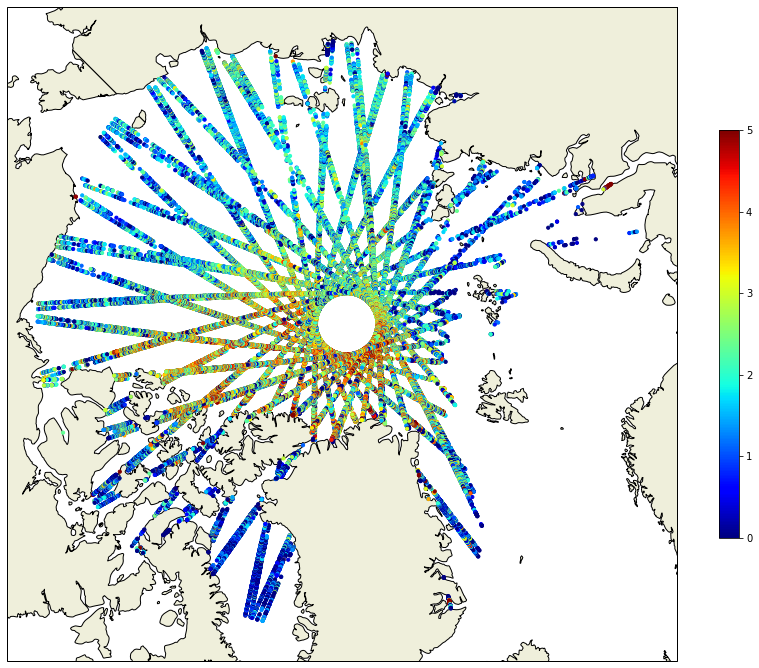

In [20]:
plt_stp = 2
# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
plt.figure(figsize=(15,15))
ax = plt.axes(projection=dst_crs)
ax.add_feature(land_50m, zorder=0, edgecolor='black')

for x, y, sit, sic, time, lon, lat in orbits:
    gpi = sic > 0
    sct = ax.scatter(x[gpi][::plt_stp], y[gpi][::plt_stp], 10, sit[gpi][::plt_stp], cmap='jet', vmin=0, vmax=5)
plt.colorbar(sct, ax=ax, shrink=0.5)
plt.show()

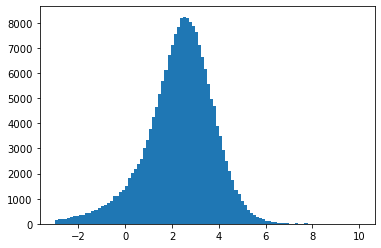

In [21]:
sit_all = np.hstack([o[2] for o in orbits])
sic_all = np.hstack([o[3] for o in orbits])

plt.hist(sit_all, 100, [-3, 10])
plt.show()

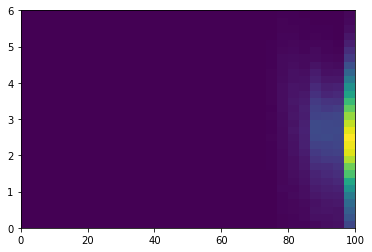

In [22]:
gpi = np.isfinite(sic_all*sic_all) * (sit_all > 0)
plt.hist2d(sic_all[gpi], sit_all[gpi], 30, [[0, 100], [0, 6]])
plt.show()

Original data


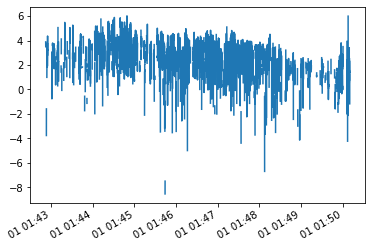

2.737170604591197 19728.401258373528
Spatial average over 3 second


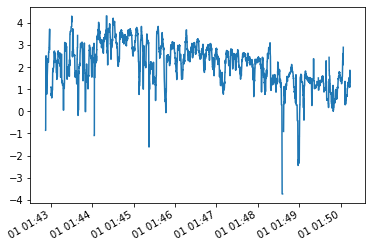

In [23]:
o = orbits[0]

sit_raw = pd.Series(o[2], index=[pd.Timestamp("2020-01-01") + pd.Timedelta(d, "sec") for d in o[4]])
print('Original data')
sit_raw.plot()
plt.show()

sat_speed = 6576.1337527911755
sat_time_18km = 18000 / sat_speed
print(sat_time_18km, sat_speed * 3)
print('Spatial average over 3 second')
sit_mean_18km = sit_raw.rolling('3 s').mean()
sit_mean_18km.plot()
plt.show()
sit_mean_18km_arr = np.array(sit_mean_18km)

In [24]:
dst_xmin = -3000000
dst_ymin = -3000000
dst_xmax = 3000000
dst_ymax = 3000000
dst_res = 6000
dst_width = int((dst_xmax - dst_xmin) / dst_res)
dst_height = int((dst_ymax - dst_ymin) / dst_res)
dst_extent = [dst_xmin, dst_ymin, dst_xmax, dst_ymax]
dst_proj4_string = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +x_0=0 +y_0=0 +a=6378273 +rf=298.27940986765 +units=m +no_defs +type=crs'

dst_area = AreaDefinition('area_id', 'descr', 'proj_id', dst_proj4_string, dst_width, dst_height, dst_extent)
orb_rows, orb_cols = dst_area.get_array_coordinates_from_lonlat(o[5],o[6])
orb_rows = orb_rows.filled(np.nan)
orb_cols = orb_cols.filled(np.nan)

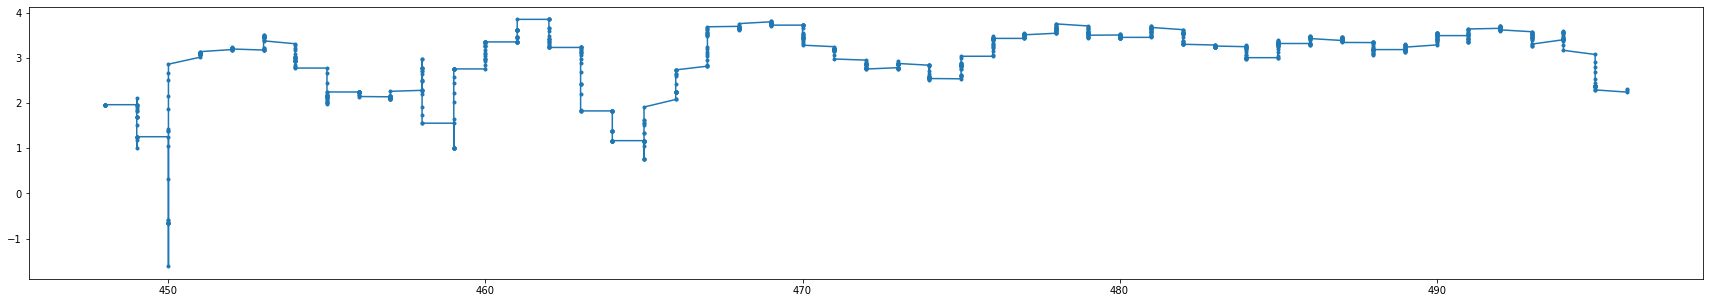

In [25]:
slc = slice(3000,4000)
plt.figure(figsize=(30, 5))
plt.plot(np.floor(orb_rows[slc]), sit_mean_18km_arr[slc], '.-')

In [26]:
sit_orbits = []
col_orbits = []
row_orbits = []

for o in orbits:
    sit_raw = pd.Series(o[2], index=[pd.Timestamp("2020-01-01") + pd.Timedelta(d, "sec") for d in o[4]])
    sit_mean_18km = sit_raw.rolling('3 s').mean()
    sit_mean_18km_arr = np.array(sit_mean_18km)
    sit_orbits.append(sit_mean_18km_arr)
    orb_cols, orb_rows = dst_area.get_array_coordinates_from_lonlat(o[5],o[6])
    col_orbits.append(orb_cols.filled(np.nan))
    row_orbits.append(orb_rows.filled(np.nan))
sit_orbits, col_orbits, row_orbits = [np.hstack(i) for i in [sit_orbits, col_orbits, row_orbits]]

In [27]:
sit_2d_p = np.zeros((dst_height, dst_width, 5)) + np.nan
sit_2d_cnt = np.zeros((dst_height, dst_width)) + np.nan

ws = 25
stp = 10
for r in range(ws, dst_height - ws, stp):
    for c in range(ws, dst_width - ws, stp):
        gpi = np.isfinite(sit_orbits) * (row_orbits >= r) * (row_orbits < r+ws)* (col_orbits >= c) * (col_orbits < c+ws)
        if gpi[gpi].size > 0:
            sit_2d_cnt[r,c] = gpi[gpi].size
            for p in range(5):
                sit_2d_p[r,c,p] = np.percentile(sit_orbits[gpi], 10*(p+1))


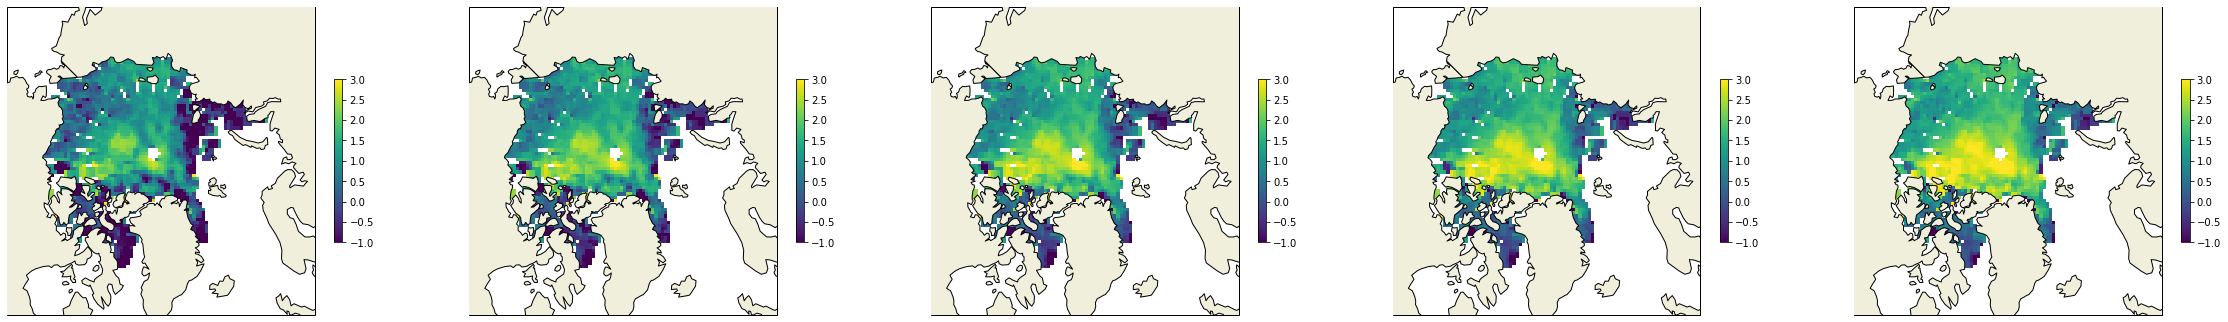

In [28]:
img_extent = [dst_xmin, dst_xmax, dst_ymax, dst_ymin]
fig_xlim = [dst_xmin, dst_xmax]
fig_ylim = [dst_ymin, dst_ymax]

fig, ax = plt.subplots(1,5, figsize=(40,10), subplot_kw=dict(projection=dst_crs))
for p in range(5):
    img = ax[p].imshow(sit_2d_p[ws::stp, ws::stp,p], interpolation='nearest', clim=[-1, 3], extent=img_extent)
    fig.colorbar(img, ax = ax[p], shrink = 0.3)
for a in ax:
    a.add_feature(cfeature.LAND, zorder=10, edgecolor='black')
    a.set_xlim(fig_xlim)
    a.set_ylim(fig_ylim)

plt.show()